In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
#%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys
sys.path.insert(1, '../../models/PFN')
from dataset_pfn import PFNDataset
from pfn_model import ParticleFlowNetwork as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns

In [61]:
#Training/Testing path
preprocessed=True
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [62]:
test_set = PFNDataset(test_path, preprocessed)
test_data, test_mask, test_label = test_set[:]

In [63]:
model = Model(input_dims = 3)
model.load_state_dict(torch.load("../../models/PFN/models/PFN_best"))
model = model.cuda()
model.eval()

FcLayers = []
for layer in model._modules['fc']:
    FcLayers.append(layer)

In [64]:
def evalFC(model, data, mask_indices = [-1], mask_values = [0.]):
    lfs = data.cuda()
    for mask_index, mask_value in zip(mask_indices, mask_values):
        if mask_index >= 0:
            lfs[:, mask_index] = mask_value*torch.ones(lfs[:, mask_index].shape)  
    for ii, layer in enumerate(FcLayers):
        if ii == len(FcLayers)-1: 
            res = layer.forward(lfs).cpu()
        elif ii == len(FcLayers)-2:
            lfs = layer.forward(lfs)
            psmax = lfs.cpu()
        else:
            lfs = layer.forward(lfs)
    return psmax, res

def evalPHI(model, test_set):
    myDL = DataLoader(test_set, batch_size=1024)
    with torch.no_grad():
        for idx, (d, m, l) in enumerate(myDL):
            d2 = torch.flatten(d, start_dim=0, end_dim=1)
            lfs = model._modules['phi'].forward(d2.cuda())
            lfs = torch.stack(torch.split(lfs.permute(1, 0), 200, dim=1), 0)
            lfs = lfs * m.cuda().bool().float()
            lfs = lfs.sum(-1)
            this_lfs = lfs.cpu()  
            psmax, res = evalFC(model, lfs)
            # res = model._modules['fc'].forward(lfs)
            if idx == 0:
                latents = this_lfs.cpu()
                labels = l.cpu()
                presoftmax = psmax.cpu()
                preds = res.cpu()
            else:
                latents = torch.cat((latents, this_lfs.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                presoftmax  = torch.cat((presoftmax, psmax.cpu()), 0)
                preds  = torch.cat((preds, res.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, presoftmax, preds

In [65]:
baseline_latents, baseline_labels, baseline_presoftmax, baseline_preds = evalPHI(model, test_set)
auc_baseline = roc_auc_score(baseline_labels[:, 0].numpy(), baseline_preds[:, 0].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 99.7387%


In [66]:
latent_means = baseline_latents.mean(0)

In [67]:
all_cols = ['z{}'.format(i) for i in range(256)]
tags = []
dresult_presoftmax = []
dresult = []
dAUC_vals = []
with torch.no_grad():
    for ii in range(latent_means.shape[0]):
        if latent_means[ii] < 0.1:
            continue
        this_presoftmax, this_preds = evalFC(model, baseline_latents, mask_indices = [ii], mask_values = [latent_means[ii]])
        tags.append('z' + str(ii))
        dresult_presoftmax.append(np.array(((baseline_presoftmax - this_presoftmax)/baseline_presoftmax).cpu().numpy()))
        dresult.append(np.array((baseline_preds - this_preds).cpu().numpy()))
        this_auc = roc_auc_score(baseline_labels[:,0].numpy(), this_preds[:,0].numpy())*100
        dAUC_vals.append(auc_baseline - this_auc)
                             
    

In [68]:
def dAUC_chart(dAUC_vals, tags, tag, save=False):
    tag = "baseline" if tag == "" else tag.strip('_')
    dAUC_vals = dAUC_vals[::-1]
    tags = tags[::-1]
    pos = np.arange(len(dAUC_vals))
    plt.figure(figsize=(10,10))
    plt.barh(pos, dAUC_vals, align='center')
    plt.yticks(pos, tags, fontsize = 10)
    plt.xlabel('Percent Drop in AUC', fontsize=10)
    plt.ylabel('Features', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dAUC_PFN_{}.png".format(tag))
    plt.show()

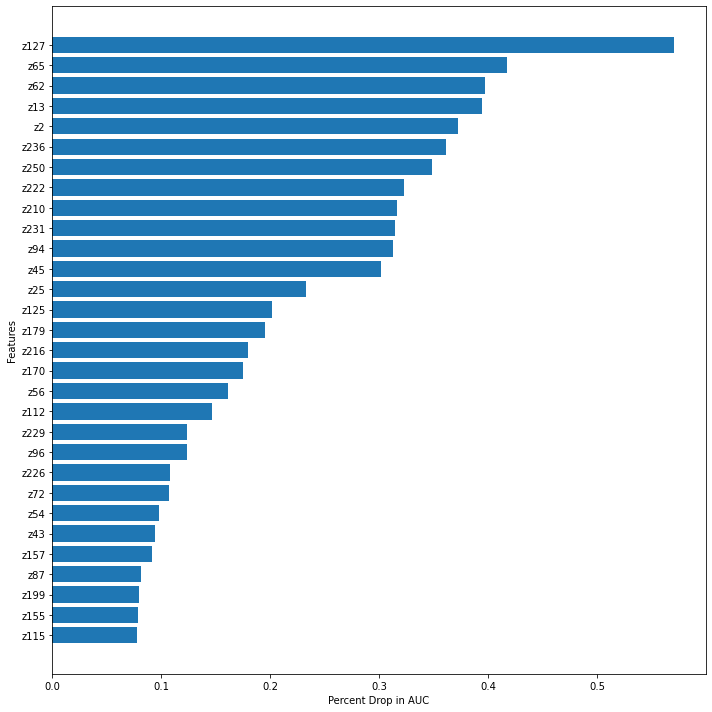

In [82]:
sorted_tags = []
sorted_vals = []
for val, tag in sorted(zip(dAUC_vals, tags), reverse = True)[:85]:
    sorted_tags.append(tag)
    sorted_vals.append(val)
dAUC_chart(sorted_vals[:30], sorted_tags[:30], tag = '')

In [70]:
mask_feats = [] # i for i in range(256)]
mask_values = [] # list(latent_means.numpy())

for ii, feat in enumerate(all_cols):
    if feat not in sorted_tags:
        mask_feats.append(int(feat.replace('z','')))
        mask_values.append(latent_means[ii])

with torch.no_grad():
    this_presoftmax, this_preds = evalFC(model, baseline_latents, 
                                         mask_indices = mask_feats, 
                                         mask_values = mask_values)
this_auc = roc_auc_score(baseline_labels[:,0].numpy(), this_preds[:,0].numpy())*100
print("Model AUC score with top 30 feats only: {:.4f}%".format(this_auc))

Model AUC score with top 30 feats only: 98.8534%


In [71]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def plotmaker(data, tags, plot_type = 'abs_bar', part_dataset = 'bkg', save = False, modelnamesuffix = ""):
    modelnamesuffix = 'baseline' if not modelnamesuffix else modelnamesuffix
    if plot_type == 'abs_bar':
        data_no_outlier = removeOutliers(data)
        plt.figure(figsize=(10,10))
        abs_data = np.nanmean(np.abs(data_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=tags, rels=abs_data))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 30
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("MAD Relevance Score", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        # plt.title("TopoDNN Absolute Value "+type_set+" Delta LRP values")
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_absbar.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()
    if plot_type == 'box_whisker':
        plt.figure(figsize=(10,10))
        df_rel_total = pd.DataFrame(removeOutliers(data), columns=tags)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(data, columns=tags)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_boxwhisker.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()

In [72]:
sig_indices = baseline_labels[:,0] == 0
bkg_indices = baseline_labels[:,0] == 1
df_sig = pd.DataFrame(baseline_latents[sig_indices], columns = all_cols).loc[:, sorted_tags]
df_bkg = pd.DataFrame(baseline_latents[bkg_indices], columns = all_cols).loc[:, sorted_tags]

In [73]:
dresult_presoftmax_bkg = []
dresult_presoftmax_sig = []
dresult_bkg = []
dresult_sig = []
for idx in range(len(tags)):
    dresult_presoftmax_bkg.append(dresult_presoftmax[idx][bkg_indices][:,0])
    dresult_presoftmax_sig.append(dresult_presoftmax[idx][sig_indices][:,1])
    dresult_bkg.append(dresult[idx][bkg_indices][:,0])
    dresult_sig.append(dresult[idx][sig_indices][:,1])

In [74]:
dresult_presoftmax_bkg = np.transpose(np.array(dresult_presoftmax_bkg))
dresult_presoftmax_sig = np.transpose(np.array(dresult_presoftmax_sig))
dresult_bkg = np.transpose(np.array(dresult_bkg))
dresult_sig = np.transpose(np.array(dresult_sig))

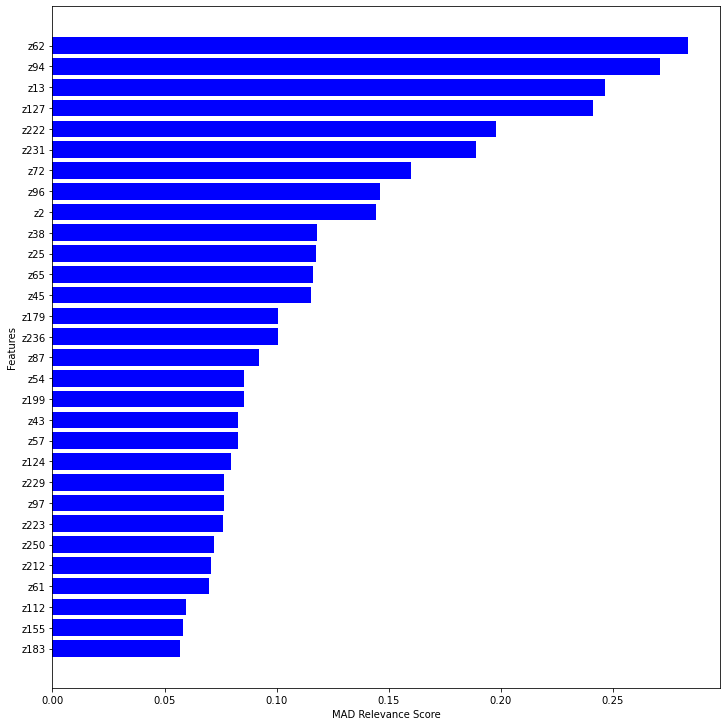

In [75]:
plotmaker(data = dresult_presoftmax_bkg, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'bkg', 
          save = False, modelnamesuffix = tag)

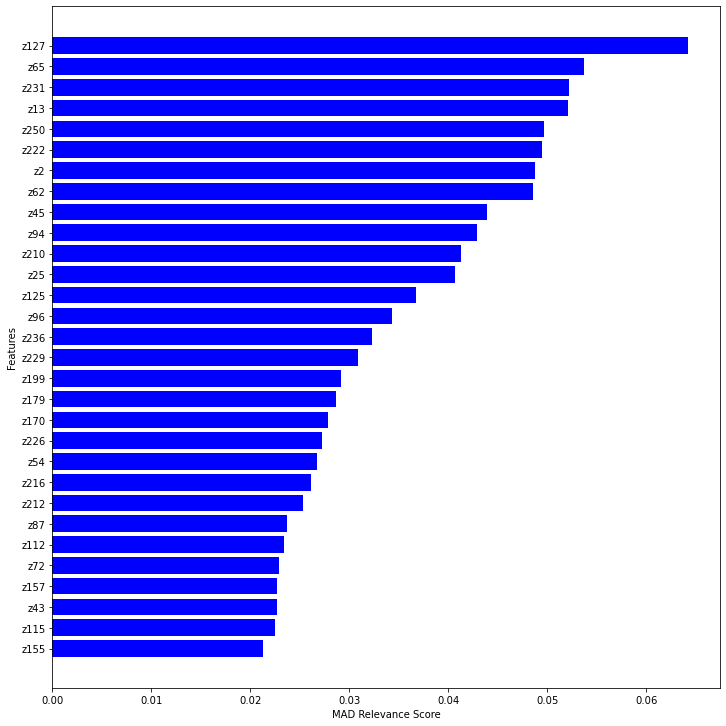

In [76]:
plotmaker(data = dresult_presoftmax_sig, tags = tags, 
          plot_type = 'abs_bar', part_dataset = 'sig', 
          save = False, modelnamesuffix = tag)

/tmp/ipykernel_205488/1238645740.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


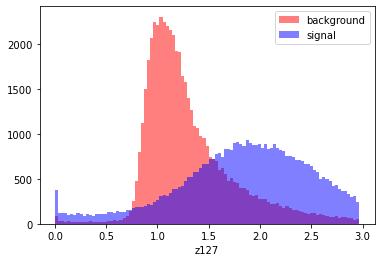

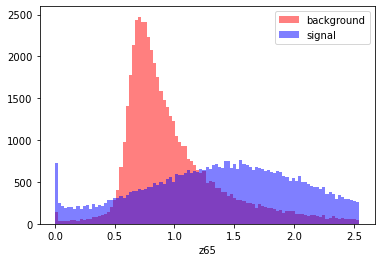

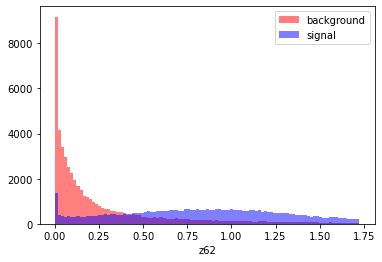

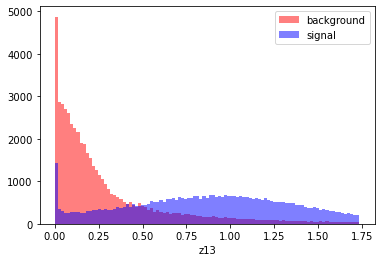

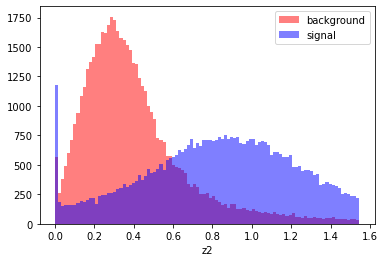

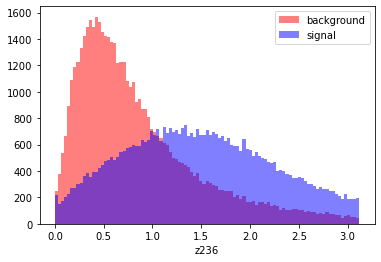

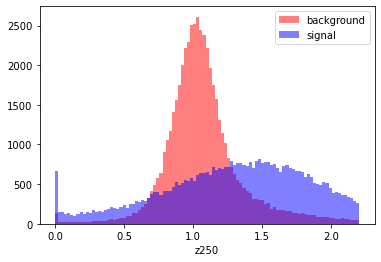

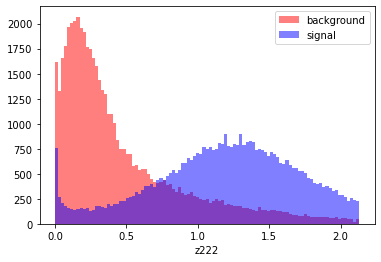

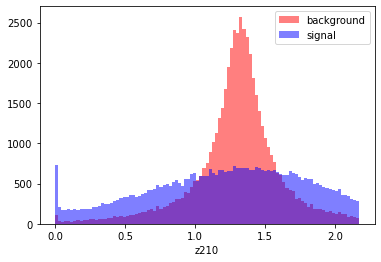

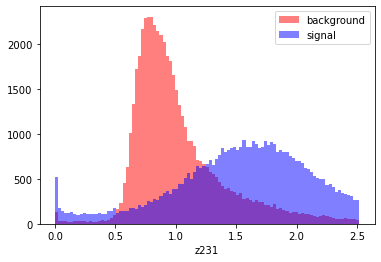

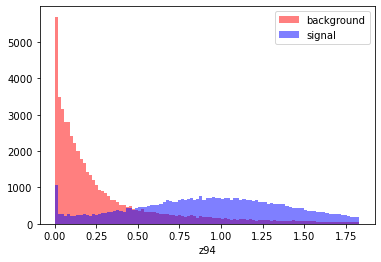

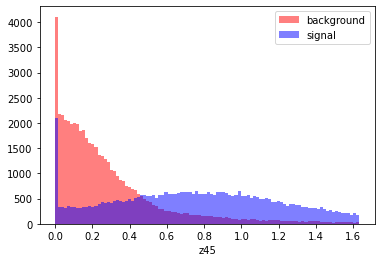

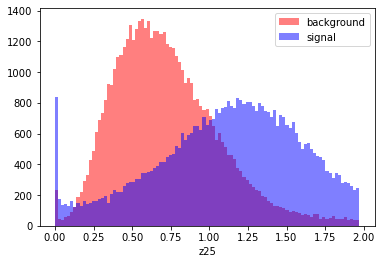

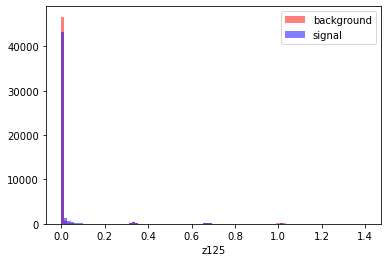

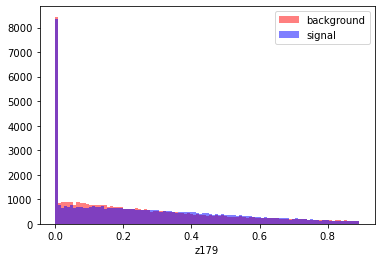

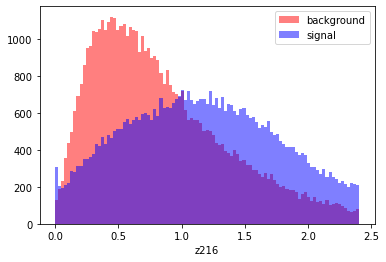

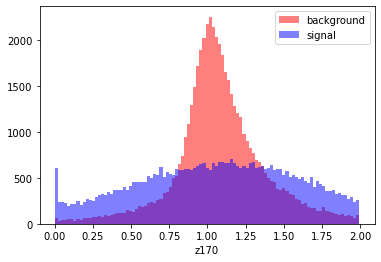

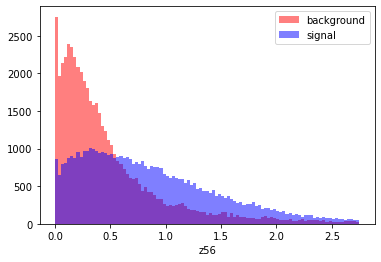

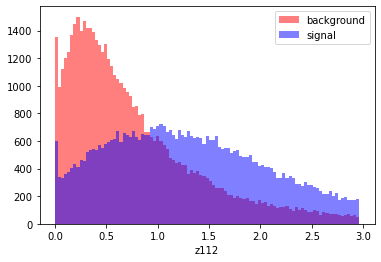

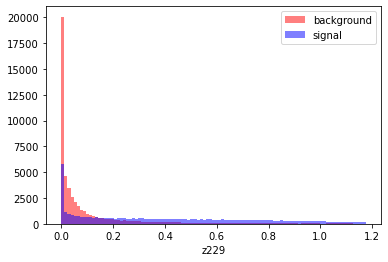

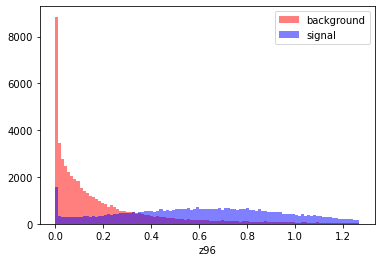

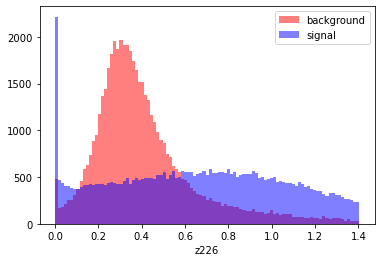

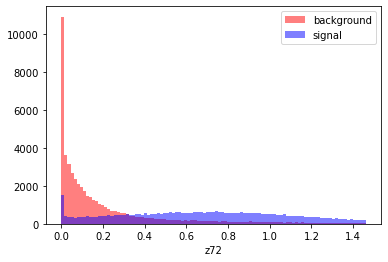

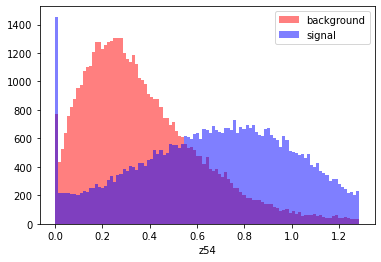

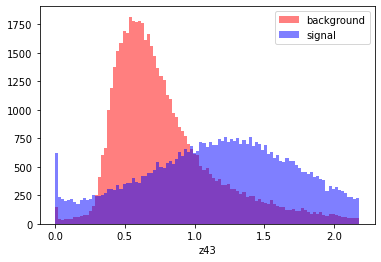

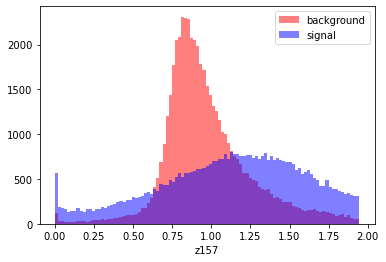

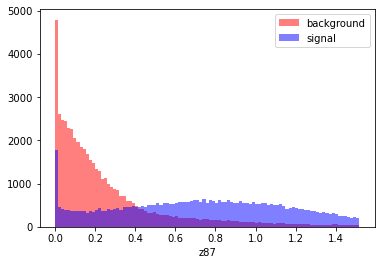

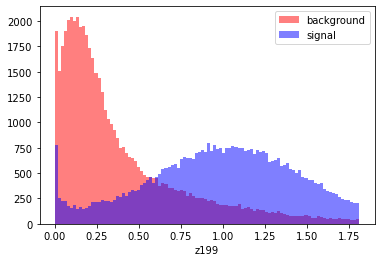

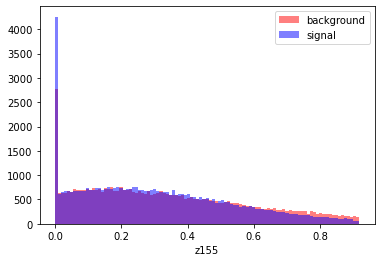

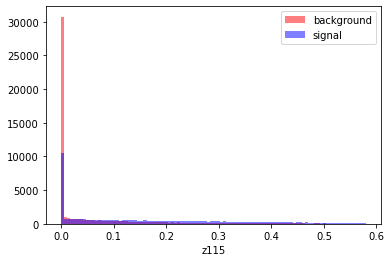

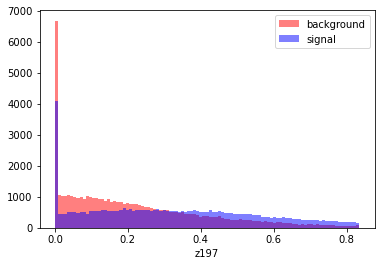

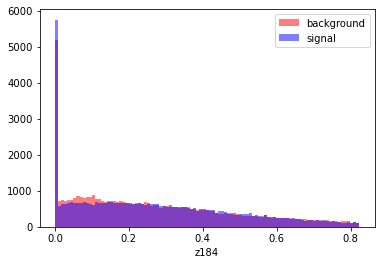

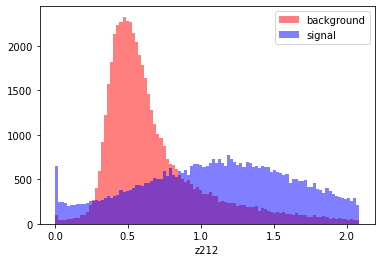

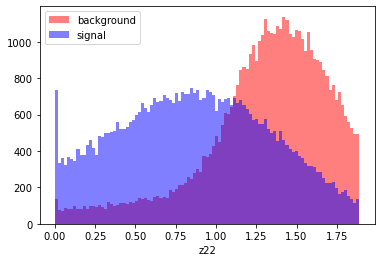

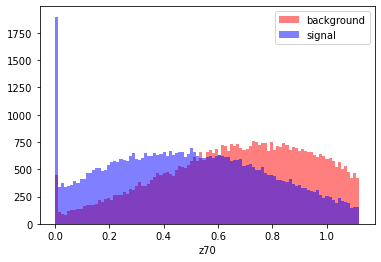

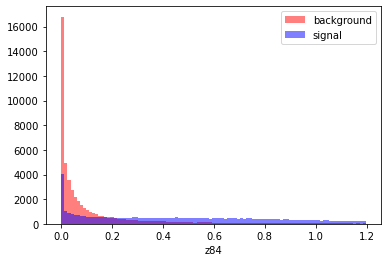

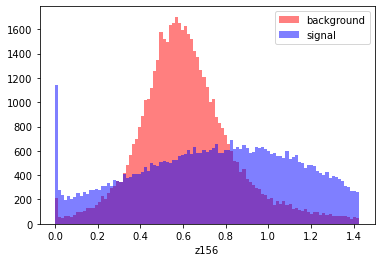

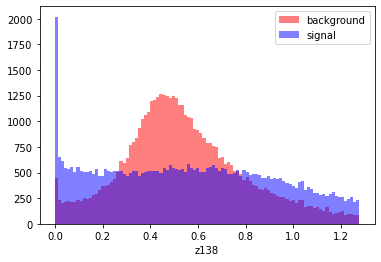

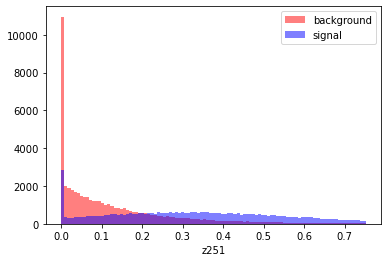

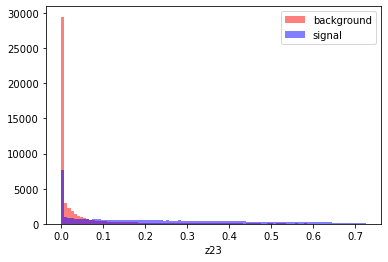

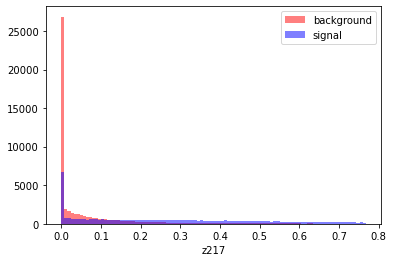

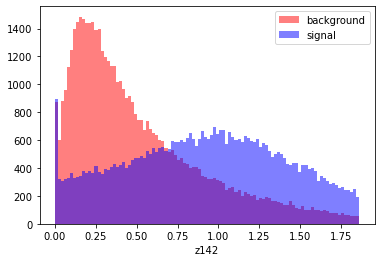

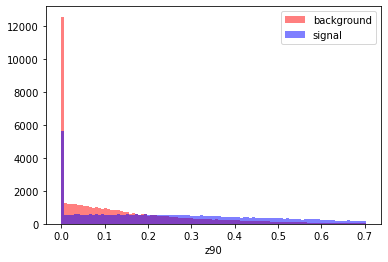

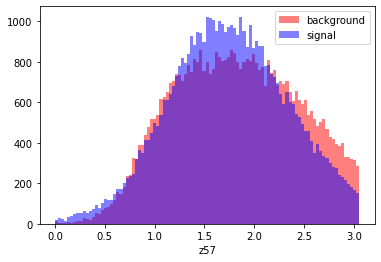

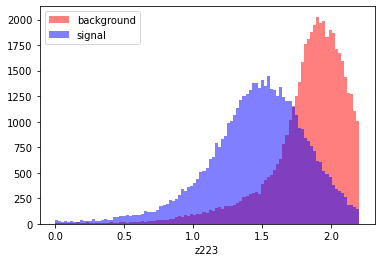

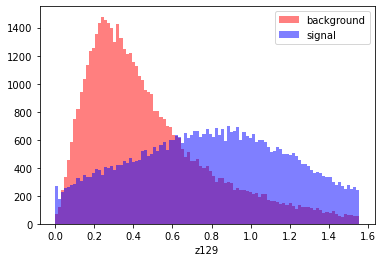

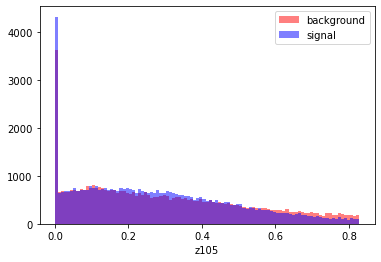

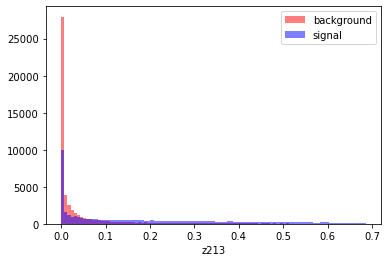

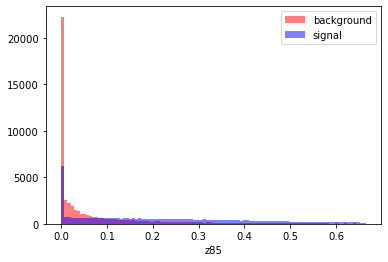

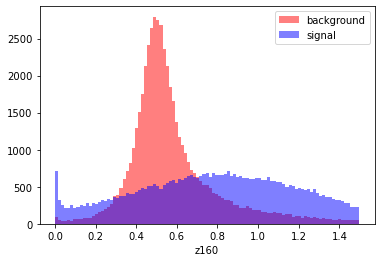

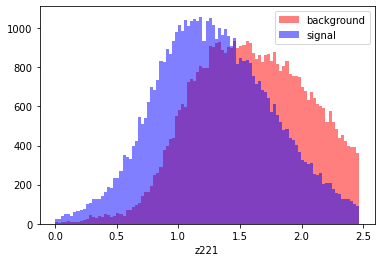

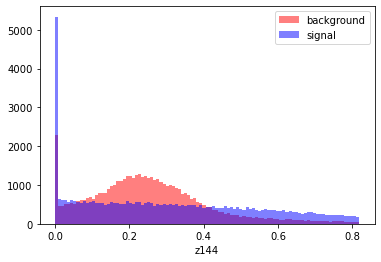

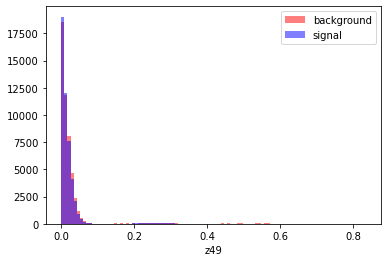

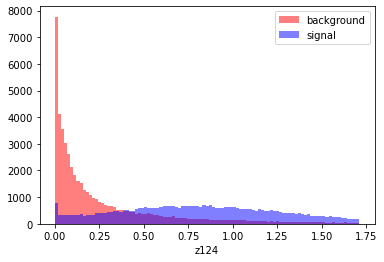

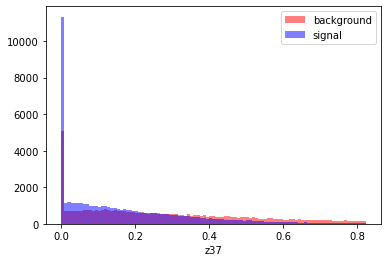

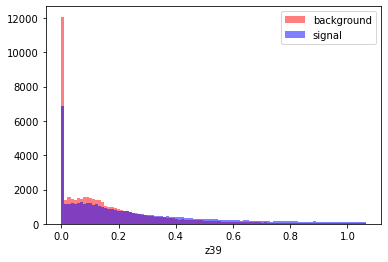

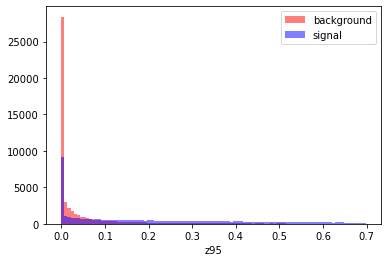

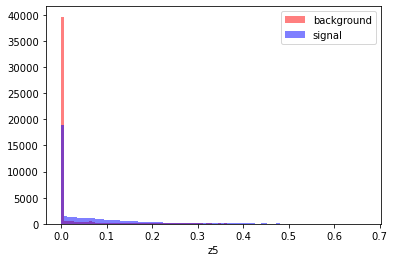

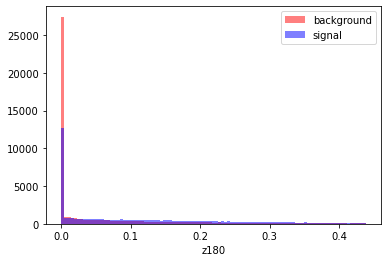

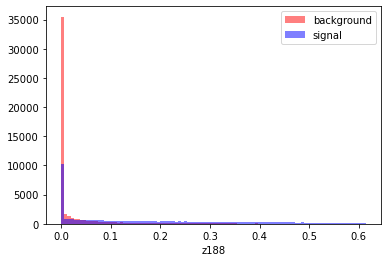

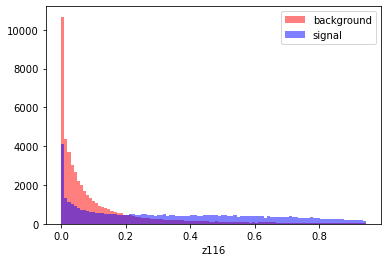

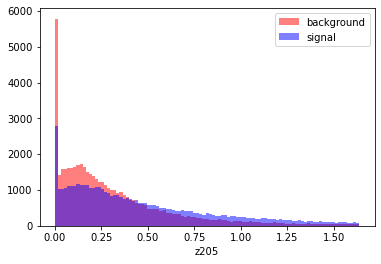

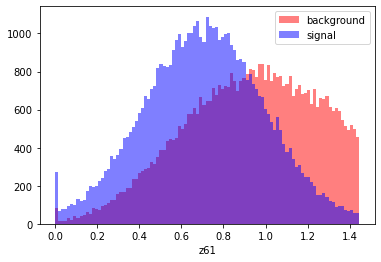

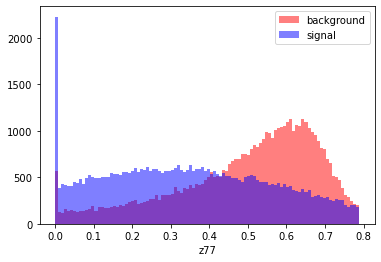

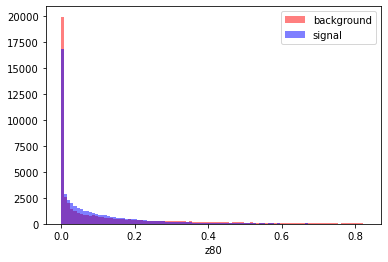

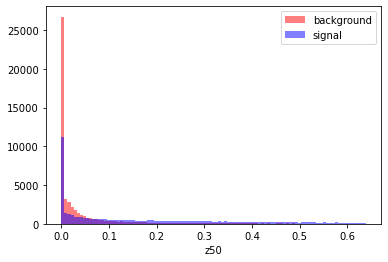

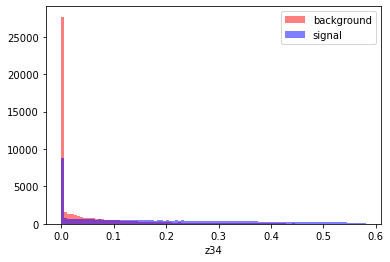

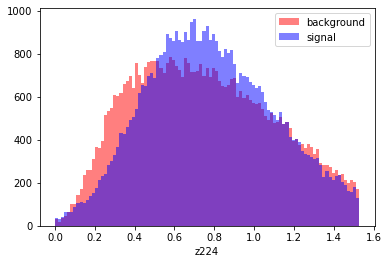

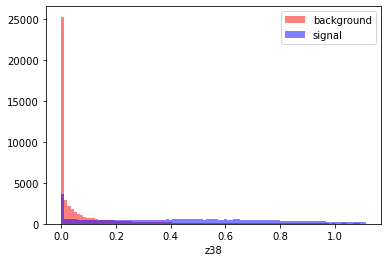

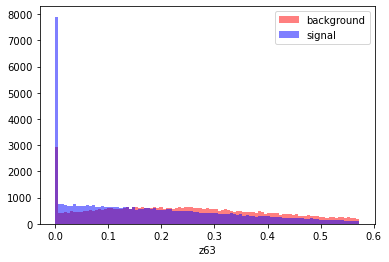

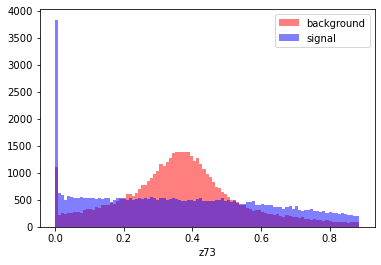

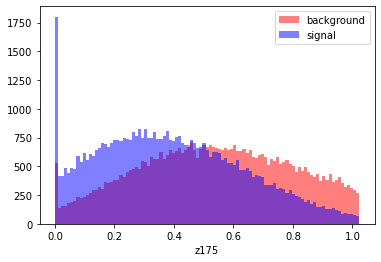

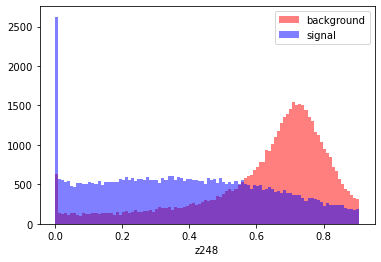

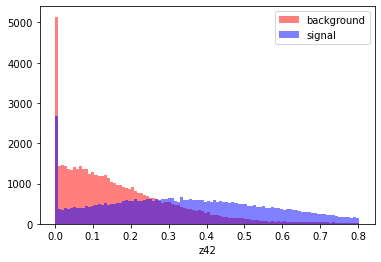

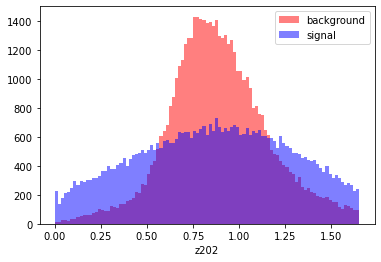

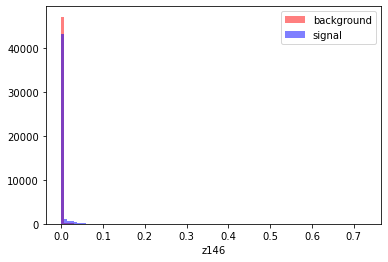

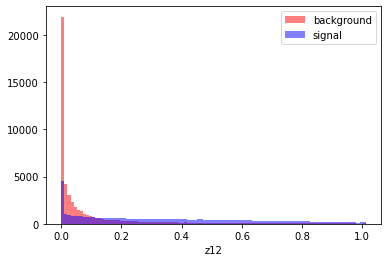

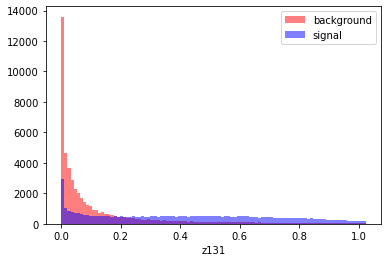

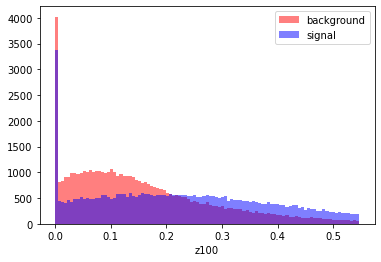

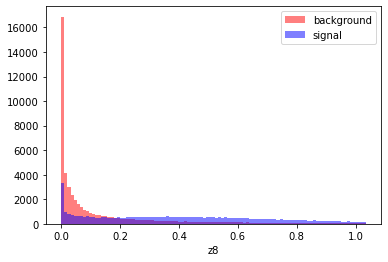

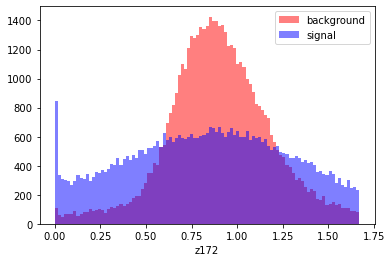

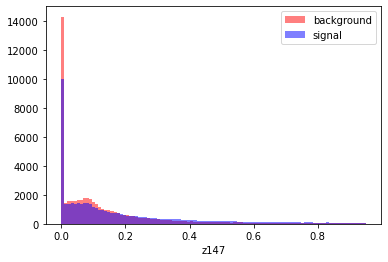

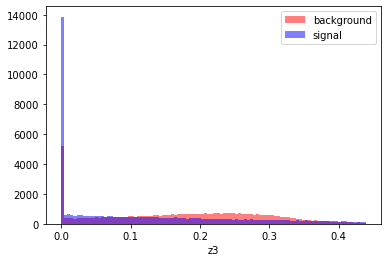

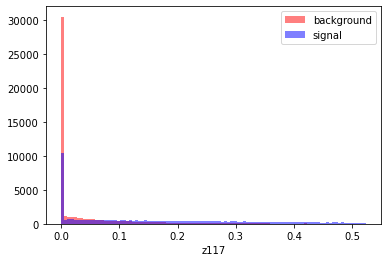

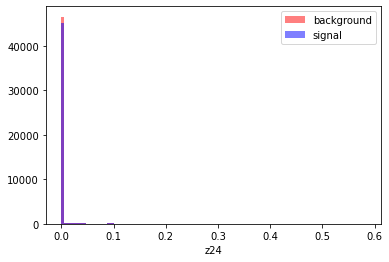

In [77]:
for ii, col in enumerate(sorted_tags):
    plt.figure()
    m = np.percentile(np.append(np.array(df_bkg[col]), np.array(df_sig[col])), 95)
    plt.hist(df_bkg[col], bins=np.arange(0,m,m/100), label='background', color='red', alpha=0.5)
    plt.hist(df_sig[col], bins=np.arange(0,m,m/100), label='signal', color='blue', alpha=0.5)
    plt.xlabel(col)
    plt.legend()

<AxesSubplot:>

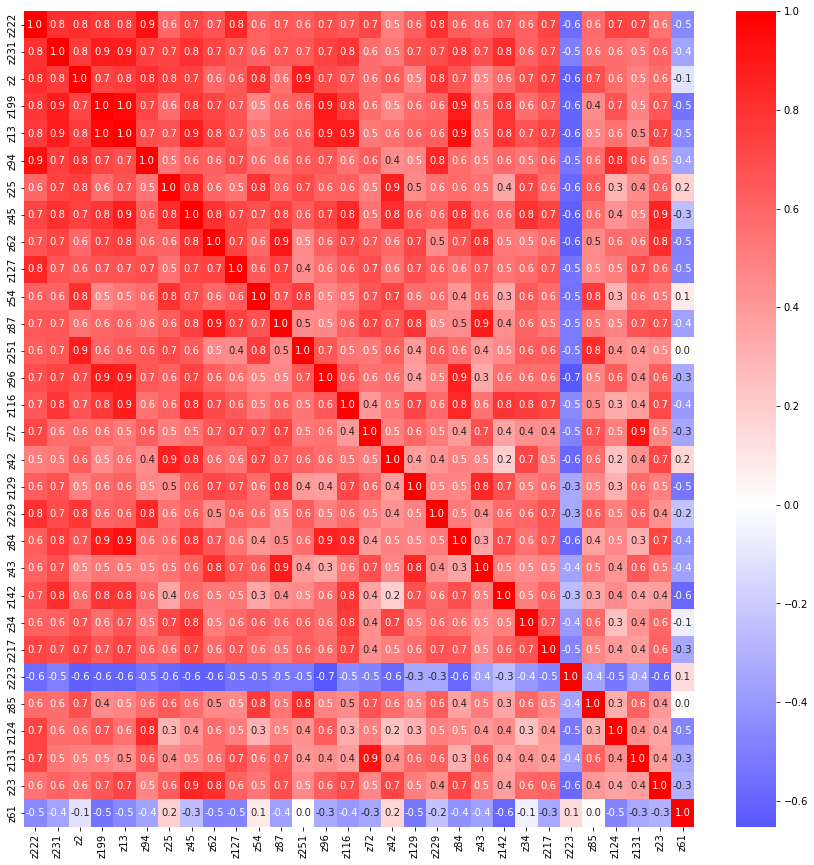

In [80]:
plt.figure(idx, figsize=(15,15))
bkg_corrmat = df_bkg.corr()
sorted_ = bkg_corrmat.abs().sum(0).sort_values(ascending=False).keys()
bkg_corrmat = bkg_corrmat.loc[sorted_[:30], sorted_[:30]]
sns.heatmap(bkg_corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')

<AxesSubplot:>

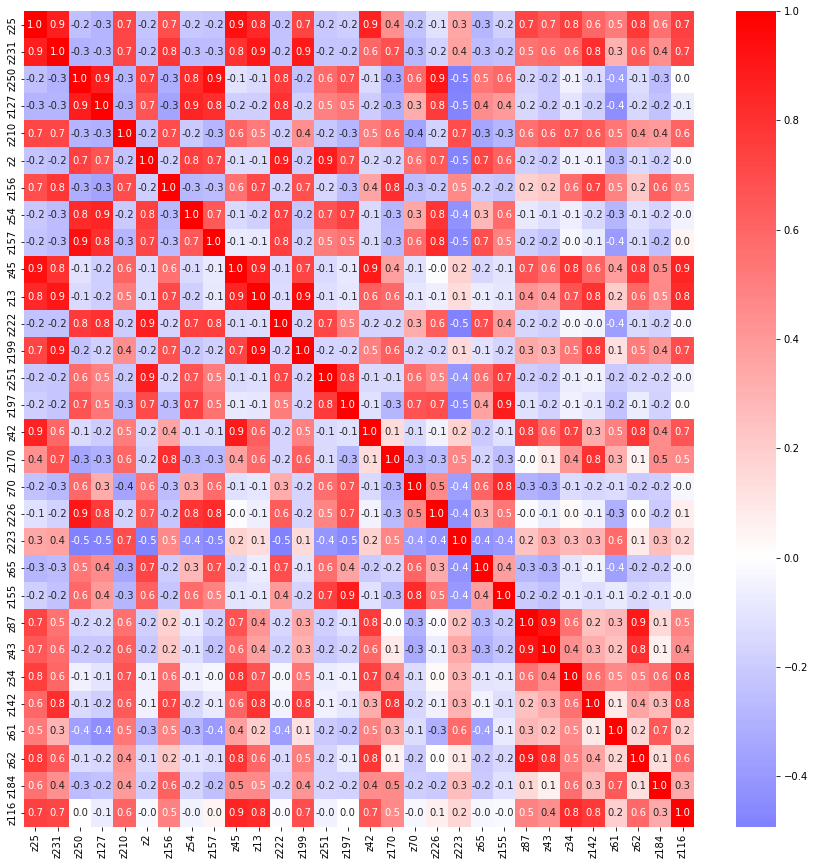

In [81]:
plt.figure(idx, figsize=(15,15))
sig_corrmat = df_sig.corr()
sorted_ = sig_corrmat.abs().sum(0).sort_values(ascending=False).keys()
sig_corrmat = sig_corrmat.loc[sorted_[:30], sorted_[:30]]
sns.heatmap(sig_corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')